In [118]:
import os
import sys

import scipy.io # to work in matlab file .amt
import scipy.misc # basic image ip/op operations. - deprecated

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

import tensorflow as tf

import pprint 


In [119]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400

# instance of the vgg model
vgg = tf.keras.applications.VGG19(include_top=False, # dont include the output layer
                                  input_shape=(img_size, img_size, 3),
                                  weights='../pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5') # path to the pretrained weights file for VGG 19

vgg.trainable = False
pp.pprint(vgg)

In [ ]:
content_image = Image.open("./Content Image.jpg")
content_image

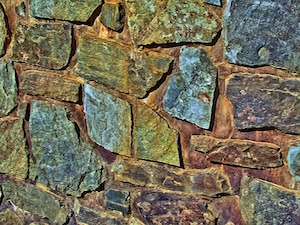

In [122]:
style_image = Image.open('./stone_style.jpg')
style_image

## Content Cost

In [123]:
def compute_content_cost(content_output, generated_output): # feature map - hiddent layer activation
    # extracts the last element - activations
    a_C = content_output[-1]
    a_G = generated_output[-1] 
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape = [m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape = [m, -1, n_C]))
    
    J_content =  1/(4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
        
    return J_content

## Style Matrix / Gram Matrix

In [124]:
def gram_matrix(A): # (n_C, n_H * n_W)
    # to capture the style of the image
  
    GA = tf.matmul(A, tf.transpose(A))

    return GA # (n_C, n_C

## Style Cost

In [125]:
def compute_layer_style_cost(a_S, a_G): # (1, n_H, n_W, n_C) -- hiddent layer activation
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) 
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = 1/(2 * n_C * n_W * n_H)**2 * tf.reduce_sum(tf.square(GS - GG))
        
    return J_style_layer

In [126]:
for layer in vgg.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [127]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [128]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [130]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    # extracting the hidden layer activation a_S
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [131]:
# it allows tensorflow to optimize and execute the function efficiently
@tf.function() # decorator converts the python function into a tensorflow graph for improved performance during computation.
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

(1, 400, 400, 3)


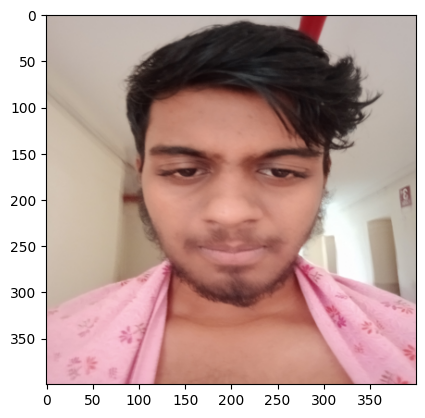

In [132]:
content_image = np.array(Image.open("./Content Image.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape))) # adding the singleton dimention

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


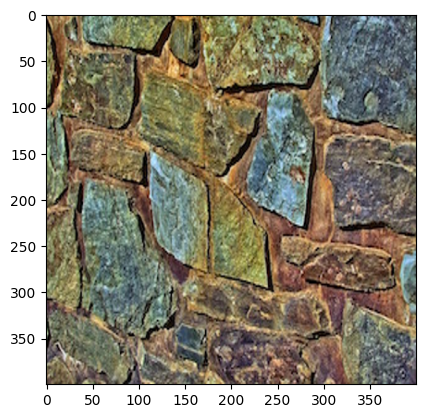

In [134]:
style_image =  np.array(Image.open("./stone_style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

## Random Initialization of the image to be generated

(1, 400, 400, 3)


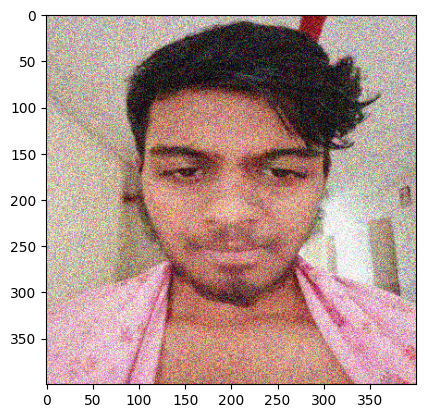

In [135]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
# after adding the noise, its possible that some pixel values could be output [0, 1], so we clip it
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [136]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [137]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [138]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [139]:
# Assign the content image to be the input of the VGG model.  
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
# Set a_C to be the hidden layer activation from the layer we have selected
a_C = vgg_model_outputs(preprocessed_content)

In [140]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [141]:
def clip_0_1(image): # all pixels in the range [0, 1]

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3: # if more than 3 dim, it means it has batch of images
        assert tensor.shape[0] == 1 # raises erro, it has convert only one dim
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [142]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style, 10, 40) 
                
    grad = tape.gradient(J, generated_image) # grad of J wrt generated image

    optimizer.apply_gradients([(grad, generated_image)]) # apply grad to update the generated image
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [143]:
generated_image = tf.Variable(generated_image)

In [ ]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"Stone_Outputs/image_{i}.jpg")
        plt.show() 